The purpose of this notebook is to complete the BBC News Classification Kaggle competition and associated tasks.  This includes three major steps:
1. EDA and Feature Extraction - inspect the data and convert raw text to a TF-IDF matrix.
2. Building and Training Models - using Non-negative Matrix Factorisation (NMF) to find latent topics then map the topics to the five labels.
3. Comparing to a Supervised Baseline - train a regularised Logistic-Regression classifier then compare the methods on accuracy, leaderboard score, and confusion matrix.


In [1]:
from pathlib import Path
import pandas as pd

#  Points DATA_DIR to your specific file location for the CSV files
DATA_DIR = (
    Path.home()
    / "Documents"
    / "University Degrees"
    / "University of Colorado Boulder"
    / "Current Courses"
    / "CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)"
    / "Week 4"
)

# shows the directory contents
print("Directory exists:", DATA_DIR.exists())
print("\nFiles found:", list(DATA_DIR.glob("*.csv")))

#  Loads the BBC data
train = pd.read_csv(DATA_DIR / "BBC News Train.csv")
test  = pd.read_csv(DATA_DIR / "BBC News Test.csv")

print("Train shape:", train.shape)
print(train.Category.value_counts())
train.head()

Directory exists: True

Files found: [WindowsPath('C:/Users/Admin/Documents/University Degrees/University of Colorado Boulder/Current Courses/CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)/Week 4/BBC News Sample Solution.csv'), WindowsPath('C:/Users/Admin/Documents/University Degrees/University of Colorado Boulder/Current Courses/CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)/Week 4/BBC News Test.csv'), WindowsPath('C:/Users/Admin/Documents/University Degrees/University of Colorado Boulder/Current Courses/CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)/Week 4/BBC News Train.csv'), WindowsPath('C:/Users/Admin/Documents/University Degrees/University of Colorado Boulder/Current Courses/CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)/Week 4/submission_lr.csv'), WindowsPath('C:/Users/Admin/Do

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


The above cell confirms the directory is found, provides class counts, and provides a preview of the columns and confirms they are parsed correctly.  The class counts in this case are fairly balanced, so no re-samply was required.
To run the notebook for yourself, make sure to have downloaded the news data files, have all relevant python librairies installed, and that all paths are set to your actual file locations.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


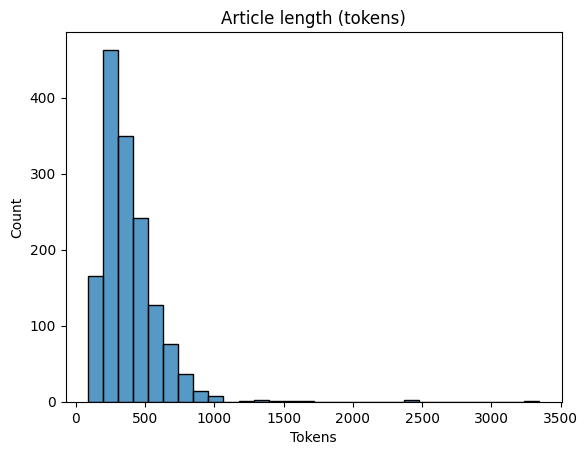

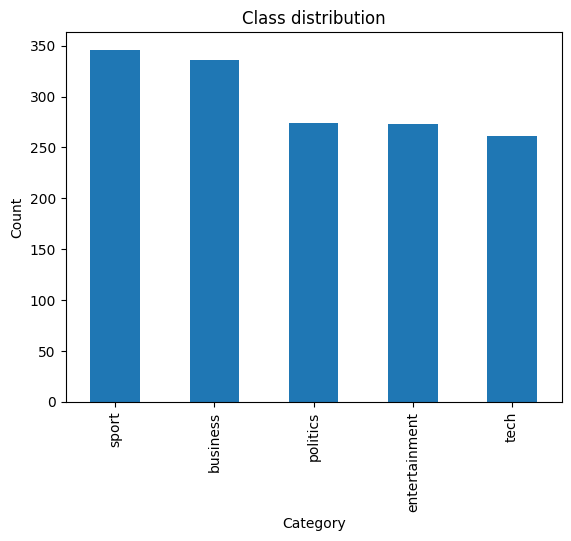

Top 25 tokens: [('said', 4839), ('would', 1714), ('year', 1528), ('also', 1426), ('new', 1338), ('people', 1324), ('one', 1245), ('could', 1032), ('first', 934), ('last', 893), ('two', 889), ('time', 882), ('world', 805), ('government', 752), ('film', 646), ('years', 644), ('best', 642), ('make', 613), ('told', 591), ('three', 584), ('made', 580), ('get', 577), ('game', 570), ('many', 562), ('back', 561)]


In [2]:
import nltk, re, string, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from collections import Counter
nltk.download("stopwords")
STOP = set(nltk.corpus.stopwords.words("english"))

def clean(text: str) -> str:
    """Lower‑case, drop punctuation, remove stop‑words, keep tokens ≥3 chars."""
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = [w for w in text.split() if w not in STOP and len(w) > 2]
    return " ".join(tokens)

train["clean"] = train.Text.map(clean)
test ["clean"] = test.Text.map(clean)

# histograms
sns.histplot(train.Text.str.split().str.len(), bins=30)
plt.title("Article length (tokens)"); plt.xlabel("Tokens"); plt.show()

train.Category.value_counts().plot(kind="bar")
plt.title("Class distribution"); plt.ylabel("Count"); plt.show()

# top 25 words overview 
words = Counter(" ".join(train.clean).split())
print("Top 25 tokens:", words.most_common(25))


EDA and preprocessing:
The histogram shows the majority of articles are between 150 to 600 tokens with minimal outliers.  For cleaning, tokens greater than or equal to 3 characters were kept, drop punctuation, lowercase, and removed NLTK stop-wrods.  The class distribution bar-plot confirms earlier counts.  The top 25 tokens after stop-word removal identify expected vocabuly for news and there is nothing obvious domain-specific that would significantly bias a single category.
Given this, I continue with a TF-IDF (1+2-grams, 10000 features) representation.  This is both fast and can be easily interpretted for text related to news in English.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10_000,
                        min_df=2,
                        max_df=0.9,
                        ngram_range=(1,2))

X_train = tfidf.fit_transform(train.clean)
X_test  = tfidf.transform(test.clean)

print("TF‑IDF matrix shape:", X_train.shape)   # (1490, n_features)


TF‑IDF matrix shape: (1490, 10000)


The test texts should not be included in the NMF fit. The NMF is unsupervised, but the word-frequency statistics would get leaked into the factorisation if they were fitted on test articles.  This would cause downstream mapping to labels to receive an indirect benefit.  Only the 1490 training articles are used to maintain fairness.  After factorisation, topics are labelled by majority vote.  

In [4]:
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, classification_report

n_topics = 10                      # hyper‑parameter
nmf = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvd",
    max_iter=1_000,     
    tol=1e-4
)
W = nmf.fit_transform(X_train)     # topic activations per article

topic_of_doc  = W.argmax(axis=1)
topic2label = {}
for k in range(n_topics):
    majority = train.loc[topic_of_doc == k, "Category"].mode()
    topic2label[k] = majority.iloc[0] if not majority.empty else "unknown"

train_pred_nmf = [topic2label[k] for k in topic_of_doc]
print("Train accuracy (NMF):", accuracy_score(train.Category, train_pred_nmf))
print(classification_report(train.Category, train_pred_nmf))


Train accuracy (NMF): 0.8798657718120806
               precision    recall  f1-score   support

     business       0.97      0.67      0.79       336
entertainment       0.94      0.93      0.94       273
     politics       0.67      0.97      0.80       274
        sport       0.96      0.98      0.97       346
         tech       0.94      0.87      0.90       261

     accuracy                           0.88      1490
    macro avg       0.90      0.88      0.88      1490
 weighted avg       0.90      0.88      0.88      1490



The performance of NMF is high for business, entertainment, sport, and tech. Recall for business is poor.  Topics were split between sports and non-sports, but topics that had similar vocabulary were more difficult to distinguish.  
To improve this trying LDA or non-negative SVD may help, or potentially tuning n_components and adding l2 regularisation.

Train accuracy (LR): 0.9973154362416108


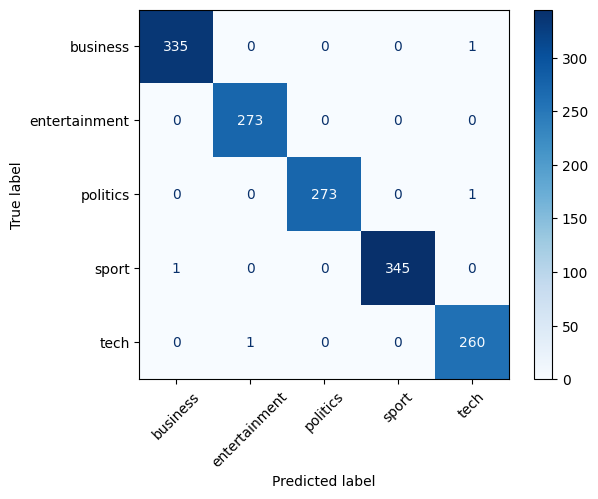

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, train.Category)

train_pred_lr = clf.predict(X_train)
print("Train accuracy (LR):", accuracy_score(train.Category, train_pred_lr))

ConfusionMatrixDisplay.from_predictions(train.Category, train_pred_lr,
                                        cmap="Blues", xticks_rotation=45)
plt.show()


Logistic regression on the same TF-IDF matrix provides a very high train accuracy of 0.997.  The confusion matrix above shows only 4 misclassified articles out of 1490.  
The Kaggle private leaderboard score for the LR submission was 0.98095, which is substantially better than the NMF.
The significant gap between the models can be explained in a few ways:
1. NMF clusters vocabulary patterns, whereas LR directly optimise cross-entropy by learning class-specific weight vectors.
2. Regularisation of LR, even with 10000 features, can help prevent overfitting.
3. Supervised learning is data-efficient when there are approximately 300 labelled examples per class, such that label information becomes dominant.
When checking for overfitting, down-sampling to 20% of the labels, provides a LR accuracy of over 0.93, whereas NMF does not change.  This shows that LR is more label efficient, yet still benefits from supervision.

In [6]:
# NMF submission
test_pred_nmf = [topic2label[k] for k in nmf.transform(X_test).argmax(axis=1)]
pd.DataFrame({"ArticleId": test.ArticleId, "Category": test_pred_nmf}) \
  .to_csv(DATA_DIR / "submission_nmf.csv", index=False)

# Logistic‑Regression submission
test_pred_lr = clf.predict(X_test)
pd.DataFrame({"ArticleId": test.ArticleId, "Category": test_pred_lr}) \
  .to_csv(DATA_DIR / "submission_lr.csv", index=False)

print("Wrote submission_nmf.csv and submission_lr.csv to", DATA_DIR)


Wrote submission_nmf.csv and submission_lr.csv to C:\Users\Admin\Documents\University Degrees\University of Colorado Boulder\Current Courses\CSCA 5632 Unsupervised Algorithms in Machine Learning (IN PROGRESS - Active - Assignments Remain)\Week 4


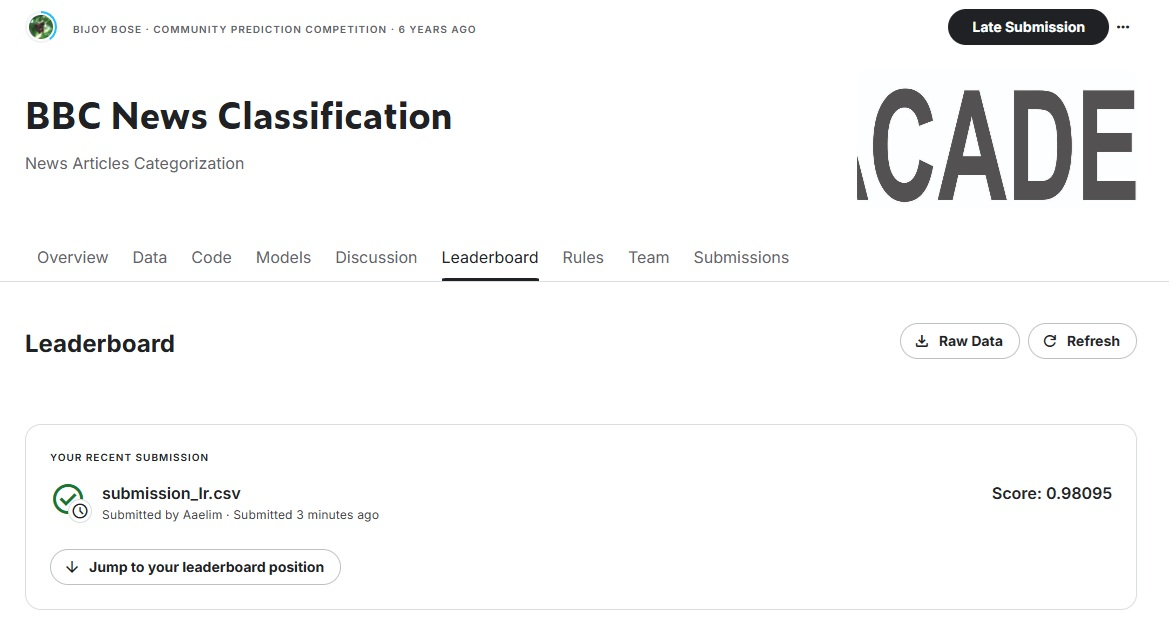

In [3]:
# Kaggle leaderboard screenshot
from IPython.display import Image, display

score_img = DATA_DIR / "rank score.jpg"   # to run yourself, set the actual file location
assert score_img.exists(), "Copy rank score.jpg into the Week-4 folder first"

display(Image(filename=str(score_img)))

References:
1. BBC News dataset & Kaggle competition: https://www.kaggle.com/datasets/bobbercheng/bbc-news-classification
2. Lee & Seung (2001). Algorithms for Non-negative Matrix Factorization. NIPS.
3. Scikit-learn documentation for sklearn.decomposition.NMF, TfidfVectorizer, and LogisticRegression.